# Here we load an existing model and plot the result

We will evaluate a pretrained model designed to predict LW heating rates and boundary fluxes.

In [1]:
#pip install climetlab
#pip install climetlab_maelstrom_radiation

In [2]:
#If running on EWC to avoid redownloading data
import os
os.environ['CLIMETLAB_MIRROR']='https://storage.ecmwf.europeanweather.cloud file:///mnt'

In [3]:
import tensorflow as tf
from tensorflow import keras 
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri
import cartopy.crs as ccrs

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


2021-12-13 15:09:21.926110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 15:09:21.948680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 15:09:21.949489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
import sys
sys.path.append('/home/mchantry/nn4ecrad/')
import plotting


In [5]:
import climetlab as cml

ds = cml.load_dataset('maelstrom-radiation',
                      dataset='tripleclouds',
                      date='20190131',
                      timestep=[0],
                      patch=list(range(16)),
                      minimal_outputs=True,raw_inputs=False,
                      topnetflux=True,
                      hr_units = 'K d-1'
                     )
dsx = ds.to_xarray()
lat = dsx.lat.load()
lon = dsx.lon.load()

#Tweak to naming convention for ease.
dsx['lw'] = dsx['fluxes_lw']

By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/licences/general/ If you do not agree with such terms, do not download the data. 


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [6]:
#Make a function to plot the data on a globe.

def zeroto360(lon,lat,z):
    #Duplicates points with lon = 0 to get nicer looking plots
    points = (lon == 0)
    lon = np.concatenate([lon,lon[points]+360])
    lat = np.concatenate([lat,lat[points]])
    z = np.concatenate([z,z[points]])
    return lon,lat,z

def surfaceplot(lon,lat,field, saveas=None, **kwargs):
    lon,lat,field =zeroto360(lon,lat,field)
    reg_lat = np.linspace(lat.min(),lat.max(),360)
    reg_lon = np.linspace(0,360,720)
    triang = tri.Triangulation(lon, lat)
    interpolator = tri.LinearTriInterpolator(triang, field)
    Xi, Yi = np.meshgrid(reg_lon, reg_lat)
    zi = interpolator(Xi, Yi)
    data_crs = ccrs.PlateCarree()

    # The projection keyword determines how the plot will look
    plt.figure(figsize=(6, 4),dpi=400)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
    hdl = ax.contourf(reg_lon, reg_lat, zi, transform=data_crs,**kwargs)
    ax.set_global()
    ax.coastlines()
    plt.colorbar(hdl,location='bottom',label=r'$W/m^2$',
                pad=0.02)
    if saveas is not None:
        plt.savefig(saveas)
    plt.show()
    return reg_lon, reg_lat, zi

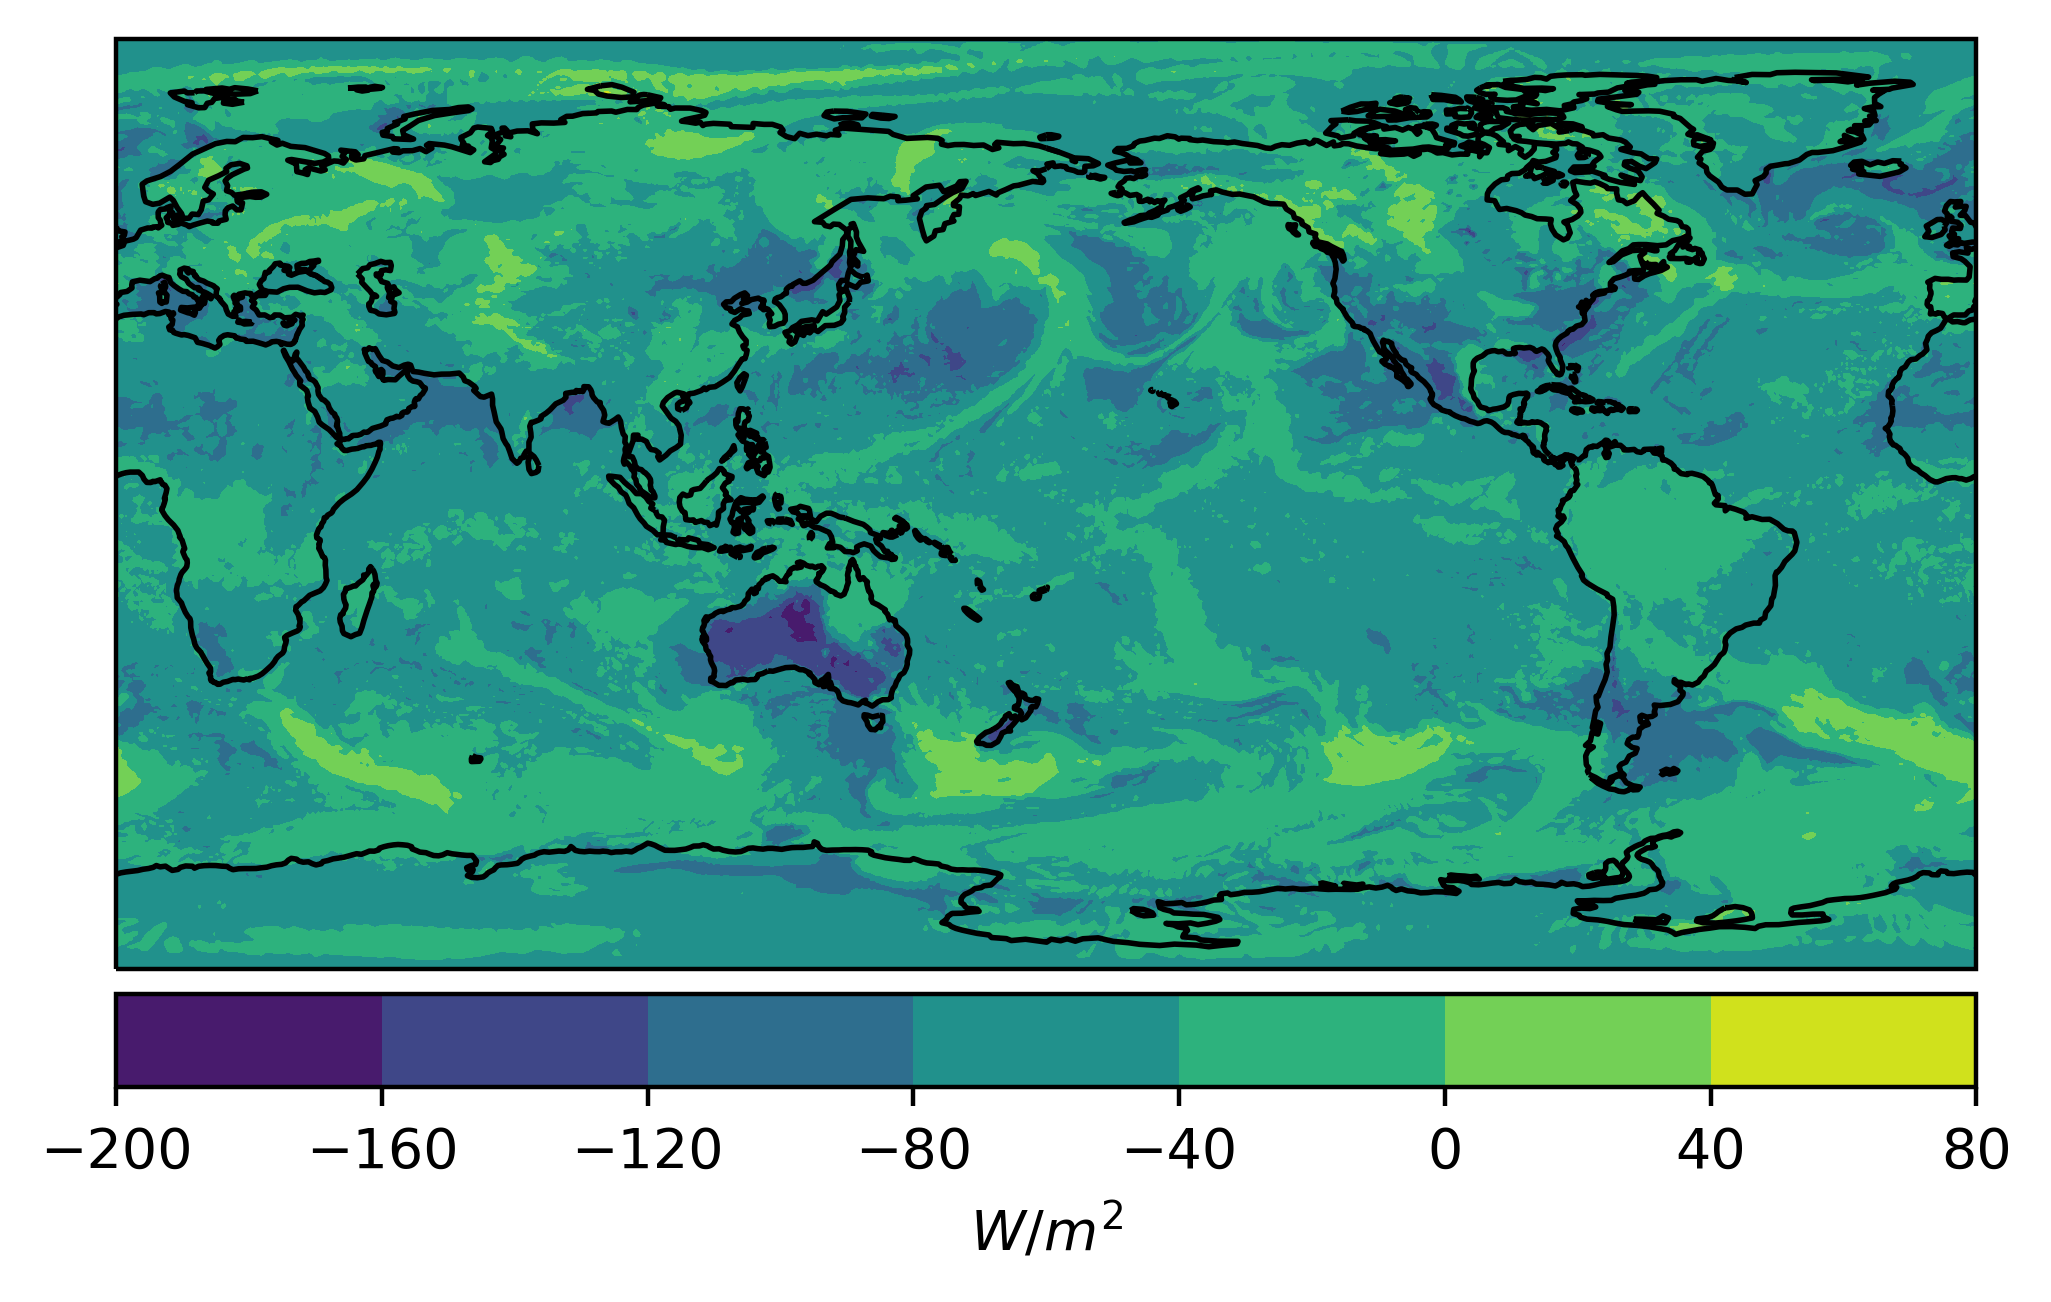

In [7]:
#Plot our truth on a surface, here we plt the net LW flux at the surface

netsurfaceflux = (dsx['fluxes_lw'][:,1] - dsx['fluxes_lw'][:,2]).data
_ = surfaceplot(lon.data,lat.data,netsurfaceflux)

# Define custom layers that the model uses.

In [8]:
@tf.keras.utils.register_keras_serializable()
class AngledSolar(tf.keras.layers.Layer):
    def __init__(self,name=None,**kwargs):
        super(AngledSolar, self).__init__(name=name,**kwargs)

    def build(self, input_shape):
        pass

    def call(self, scalar_inputs):
        return tf.concat([scalar_inputs,scalar_inputs[...,1:2]*scalar_inputs[...,-1:]],axis=-1)


In [9]:
@tf.keras.utils.register_keras_serializable()
class TopFlux(tf.keras.layers.Layer):
    def __init__(self,name=None,**kwargs):
        super(TopFlux, self).__init__(name=name,**kwargs)
        self.g_cp = tf.constant(3600 * 24 * 9.80665 / 1004)

    def build(self, input_shape):
        pass

    def call(self, inputs):
        fluxes = inputs[0]
        hr = tf.squeeze(inputs[1])
        hlpress = inputs[2]
        netflux = fluxes[...,0] - fluxes[...,1]
        net_press = hlpress[...,1:,0]-hlpress[...,:-1,0]
        hr_sum = tf.math.reduce_sum(tf.math.multiply(hr,net_press),axis=-1)
        return tf.stack([netflux + hr_sum / self.g_cp,fluxes[...,0],fluxes[...,1]],axis=-1)


# Load existing model

Replace this with loading your own model.

In [217]:
model_name = 'model_58002.h5' 

model = keras.models.load_model(model_name,
                                custom_objects = {'AngledSolar':AngledSolar,
                                                 "TopFlux":TopFlux}
                               )

# Predict from the xarray dataset

In [18]:
def predictfromxarray(model,ds):
    keys = ["sca_inputs","hl_inputs","col_inputs","inter_inputs","pressure_hl"]
    inputs = {}
    for key in keys:
        inputs[key] = ds[key].data
    return model.predict(inputs)


In [221]:
#Warning this is slow, taking ~20minutes on my machine.
pred = predictfromxarray(model,dsx)

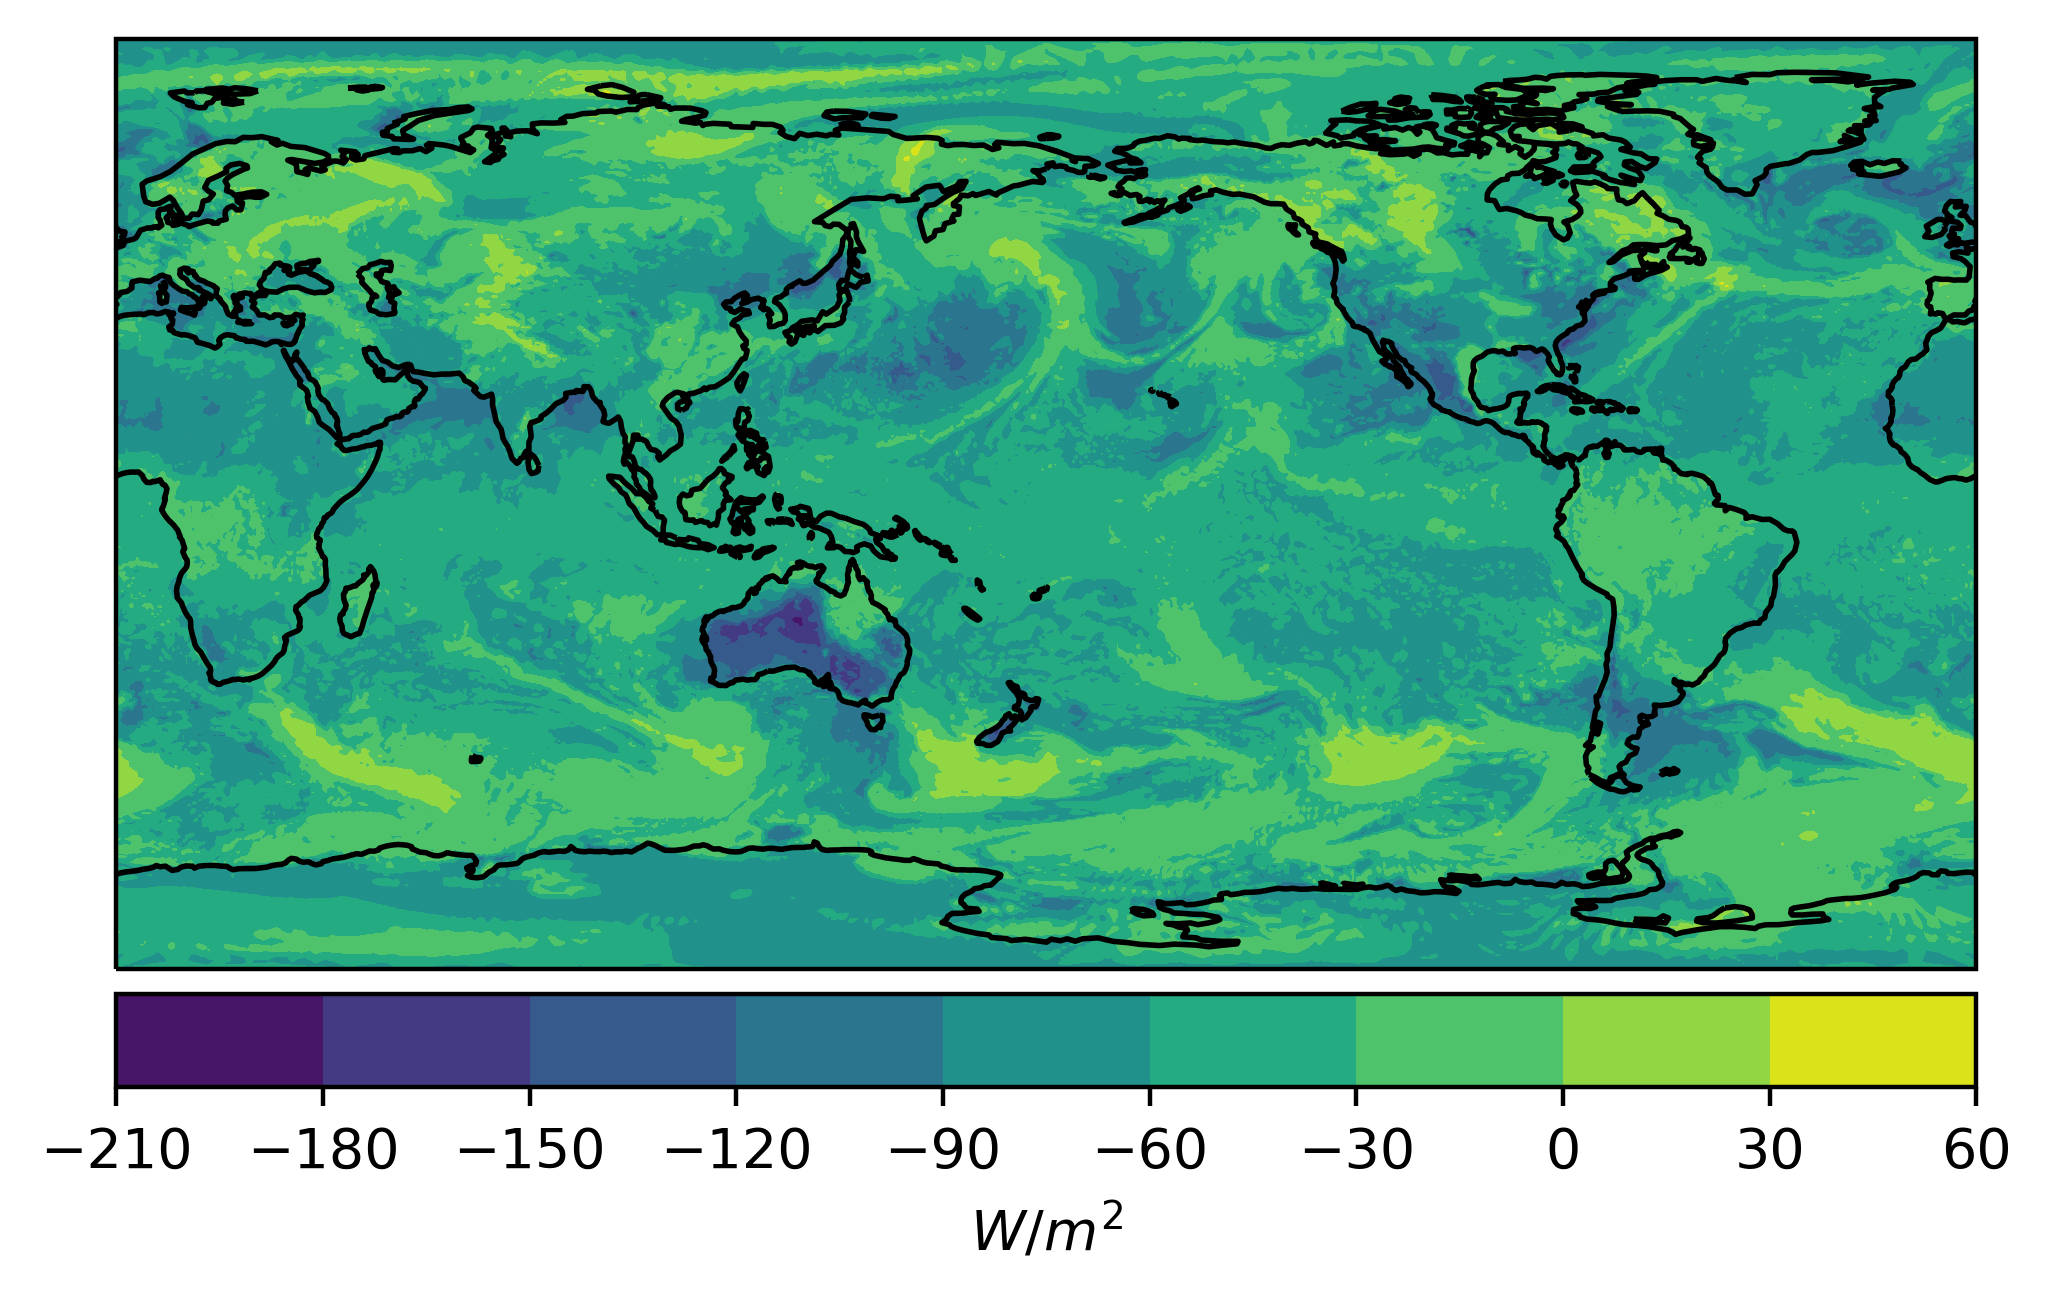

In [222]:
#Plot our truth on a surface, here we plt the net LW flux at the surface

netsurfacepred = (pred['lw'][:,1] - pred['lw'][:,2])
_ = surfaceplot(lon.data,lat.data,netsurfacepred)

# Look at the proportion of gridpoints with errors greater than various thresholds

In [234]:
for threshold in [10,5,2,1,0.5]:
    print(f"Proportion errors larger than {threshold}W/m2: {(np.abs(netsurfacepred - netsurfaceflux)>threshold).mean().compute()*100}")

Proportion larger than 10: 0.004422169811320755
Proportion larger than 5: 0.04459021226415094
Proportion larger than 2: 1.4803213443396226
Proportion larger than 1: 13.213811910377357
Proportion larger than 0.5: 41.13686615566038


# Plot the difference (note this is one time instance)

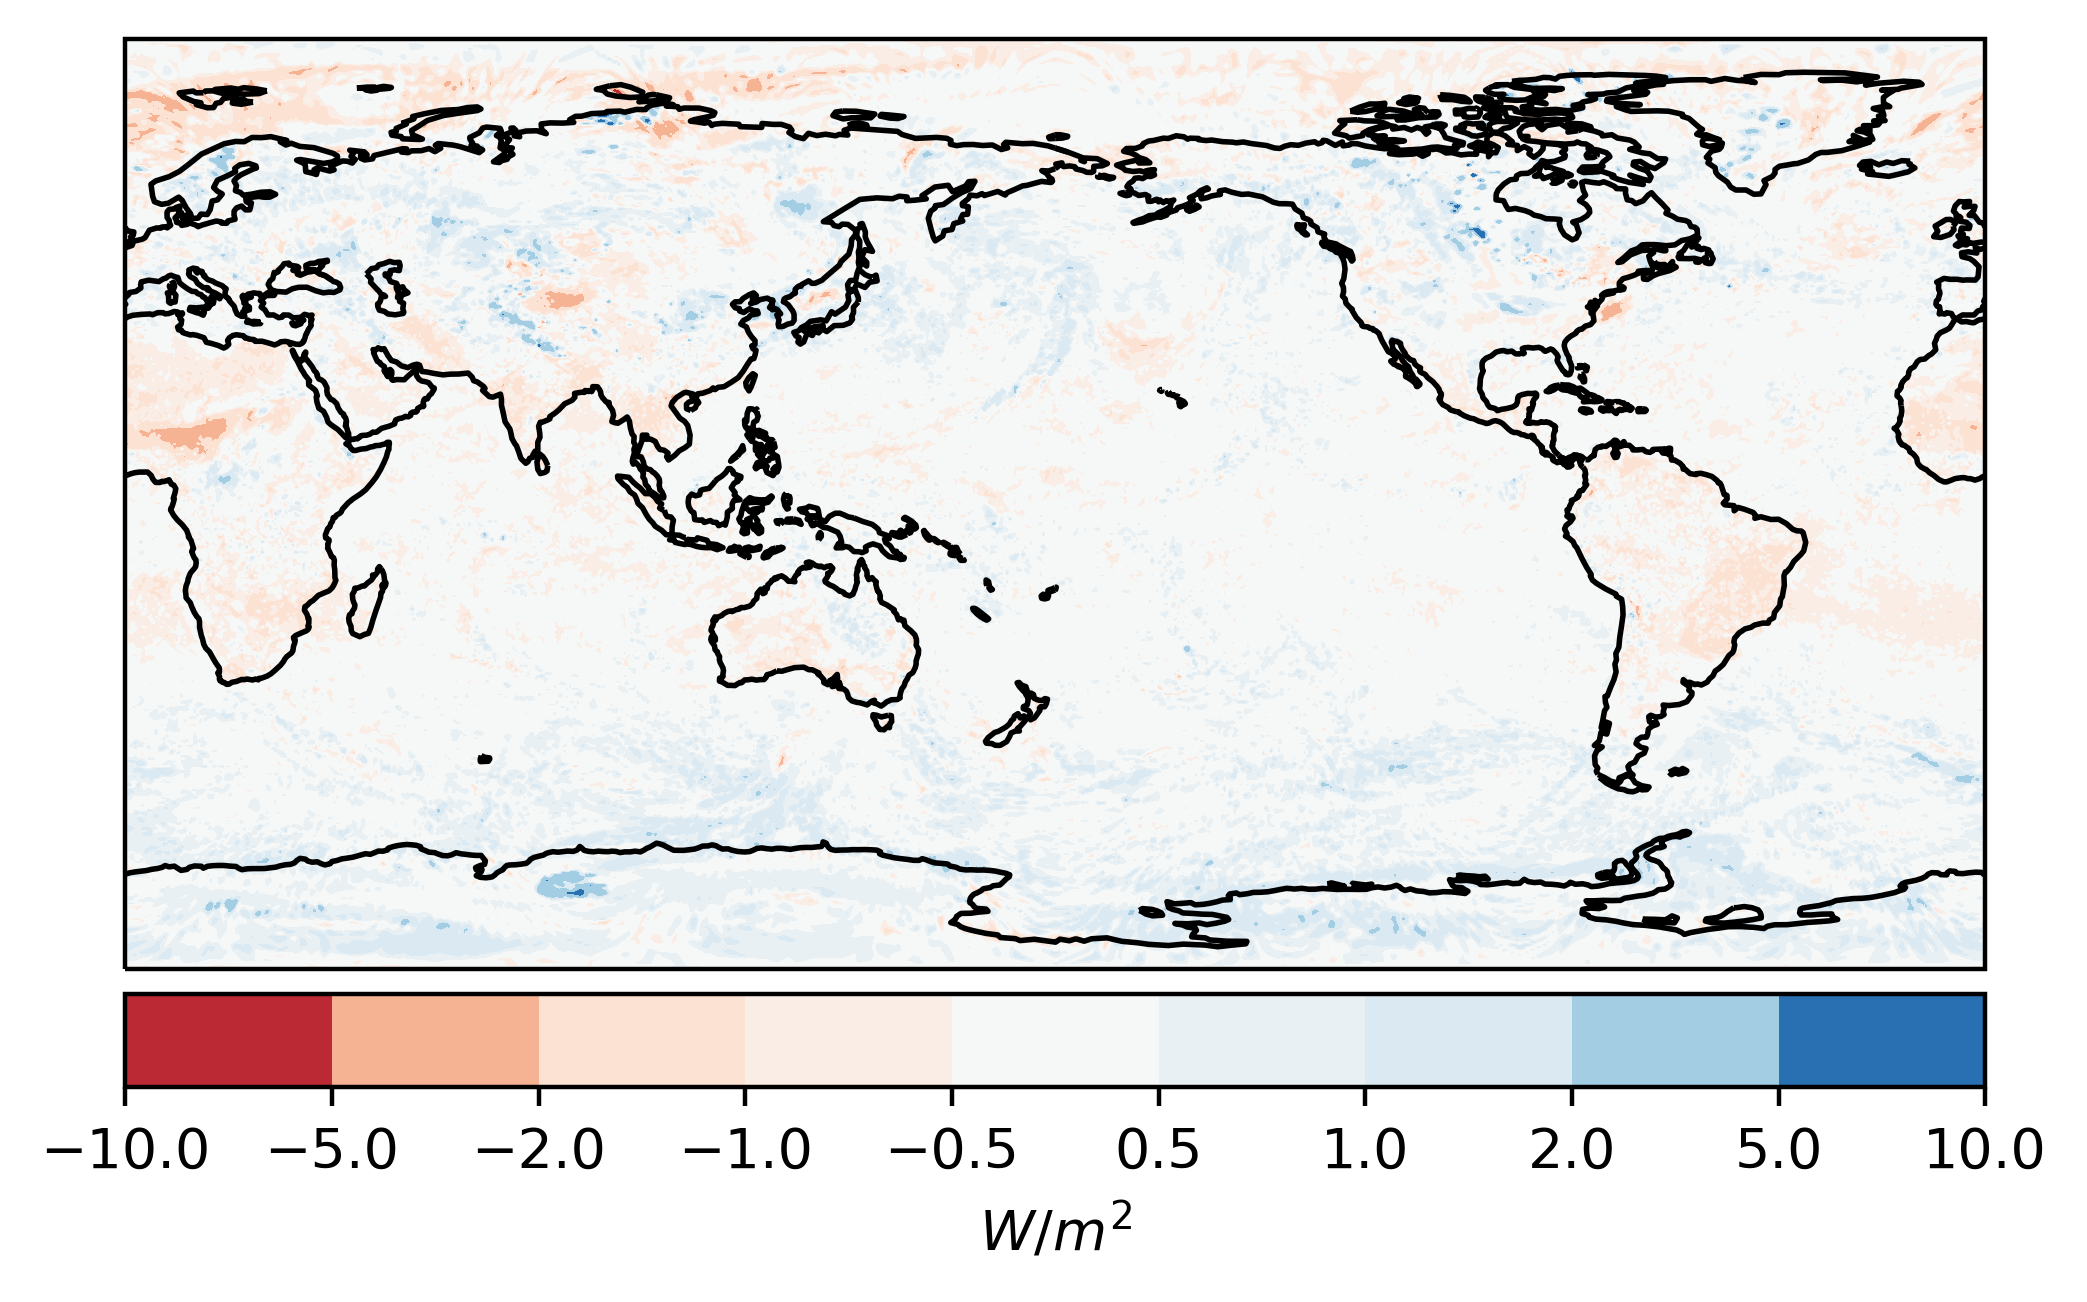

In [235]:
_ = surfaceplot(lon.data,lat.data,netsurfacepred - netsurfaceflux,
               cmap='RdBu',levels=[-10,-5,-2,-1,-0.5,0.5,1,2,5,10],
               )

In [226]:
longnames = {'hr_sw':'Shortwave heating \n rate (K/d)',
             'hr_lw':'Longwave heating \n rate (K/d)',
             'sw':'Shortwave boundary fluxes',
             'lw':'Longwave boundary fluxes',
             }

def plotbatch(batch_out,pred_batch,
              to_plot = ['sw','lw','hr_sw','hr_lw'],
              num_samples = 4,
              cloud_frac = None,
              samples = None
):
    batch_size = batch_out[to_plot[0]].shape[0]
    if samples is None:
        samples = np.random.choice(batch_size,num_samples,replace=False)
    else:
        num_samples = len(samples)
    plt.figure(figsize=(10,2*len(to_plot)+0.5),dpi=400)
    # plt.suptitle("Validation example columns")                                                                                                                                                                    
    for i,key in enumerate(to_plot):
        for j,k in enumerate(samples):
            ax1=plt.subplot(len(to_plot),num_samples,num_samples*i+j+1)
            ax1.plot(batch_out[key][k,:],label='Truth')
            if type(pred_batch) == dict:
                plt.plot(pred_batch[key][k,:],label='Prediction',alpha=0.5)
            ax = plt.gca()
            if i==0:
                plt.title(f"{k}")
            if i < len(to_plot) - 1:
                ax.axes.xaxis.set_ticklabels([])
            if j==0:
                plt.ylabel(longnames[key])
            #else:                                                                                                                                                                                                  
            #    ax.axes.yaxis.set_ticklabels([])                                                                                                                                                                   
            #if j < 2:                                                                                                                                                                                              
            #    plt.ylim([0,500])                                                                                                                                                                                  
            #else:                                                                                                                                                                                                  
            #    plt.ylim([-10,10])                                                                                                                                                                                 
            if (i == len(to_plot) - 1) and (j == num_samples - 1):
                plt.legend()
    plt.suptitle("Model Level",x=0.5,y=0)
    plt.tight_layout()
    return


# Plot a few example columns

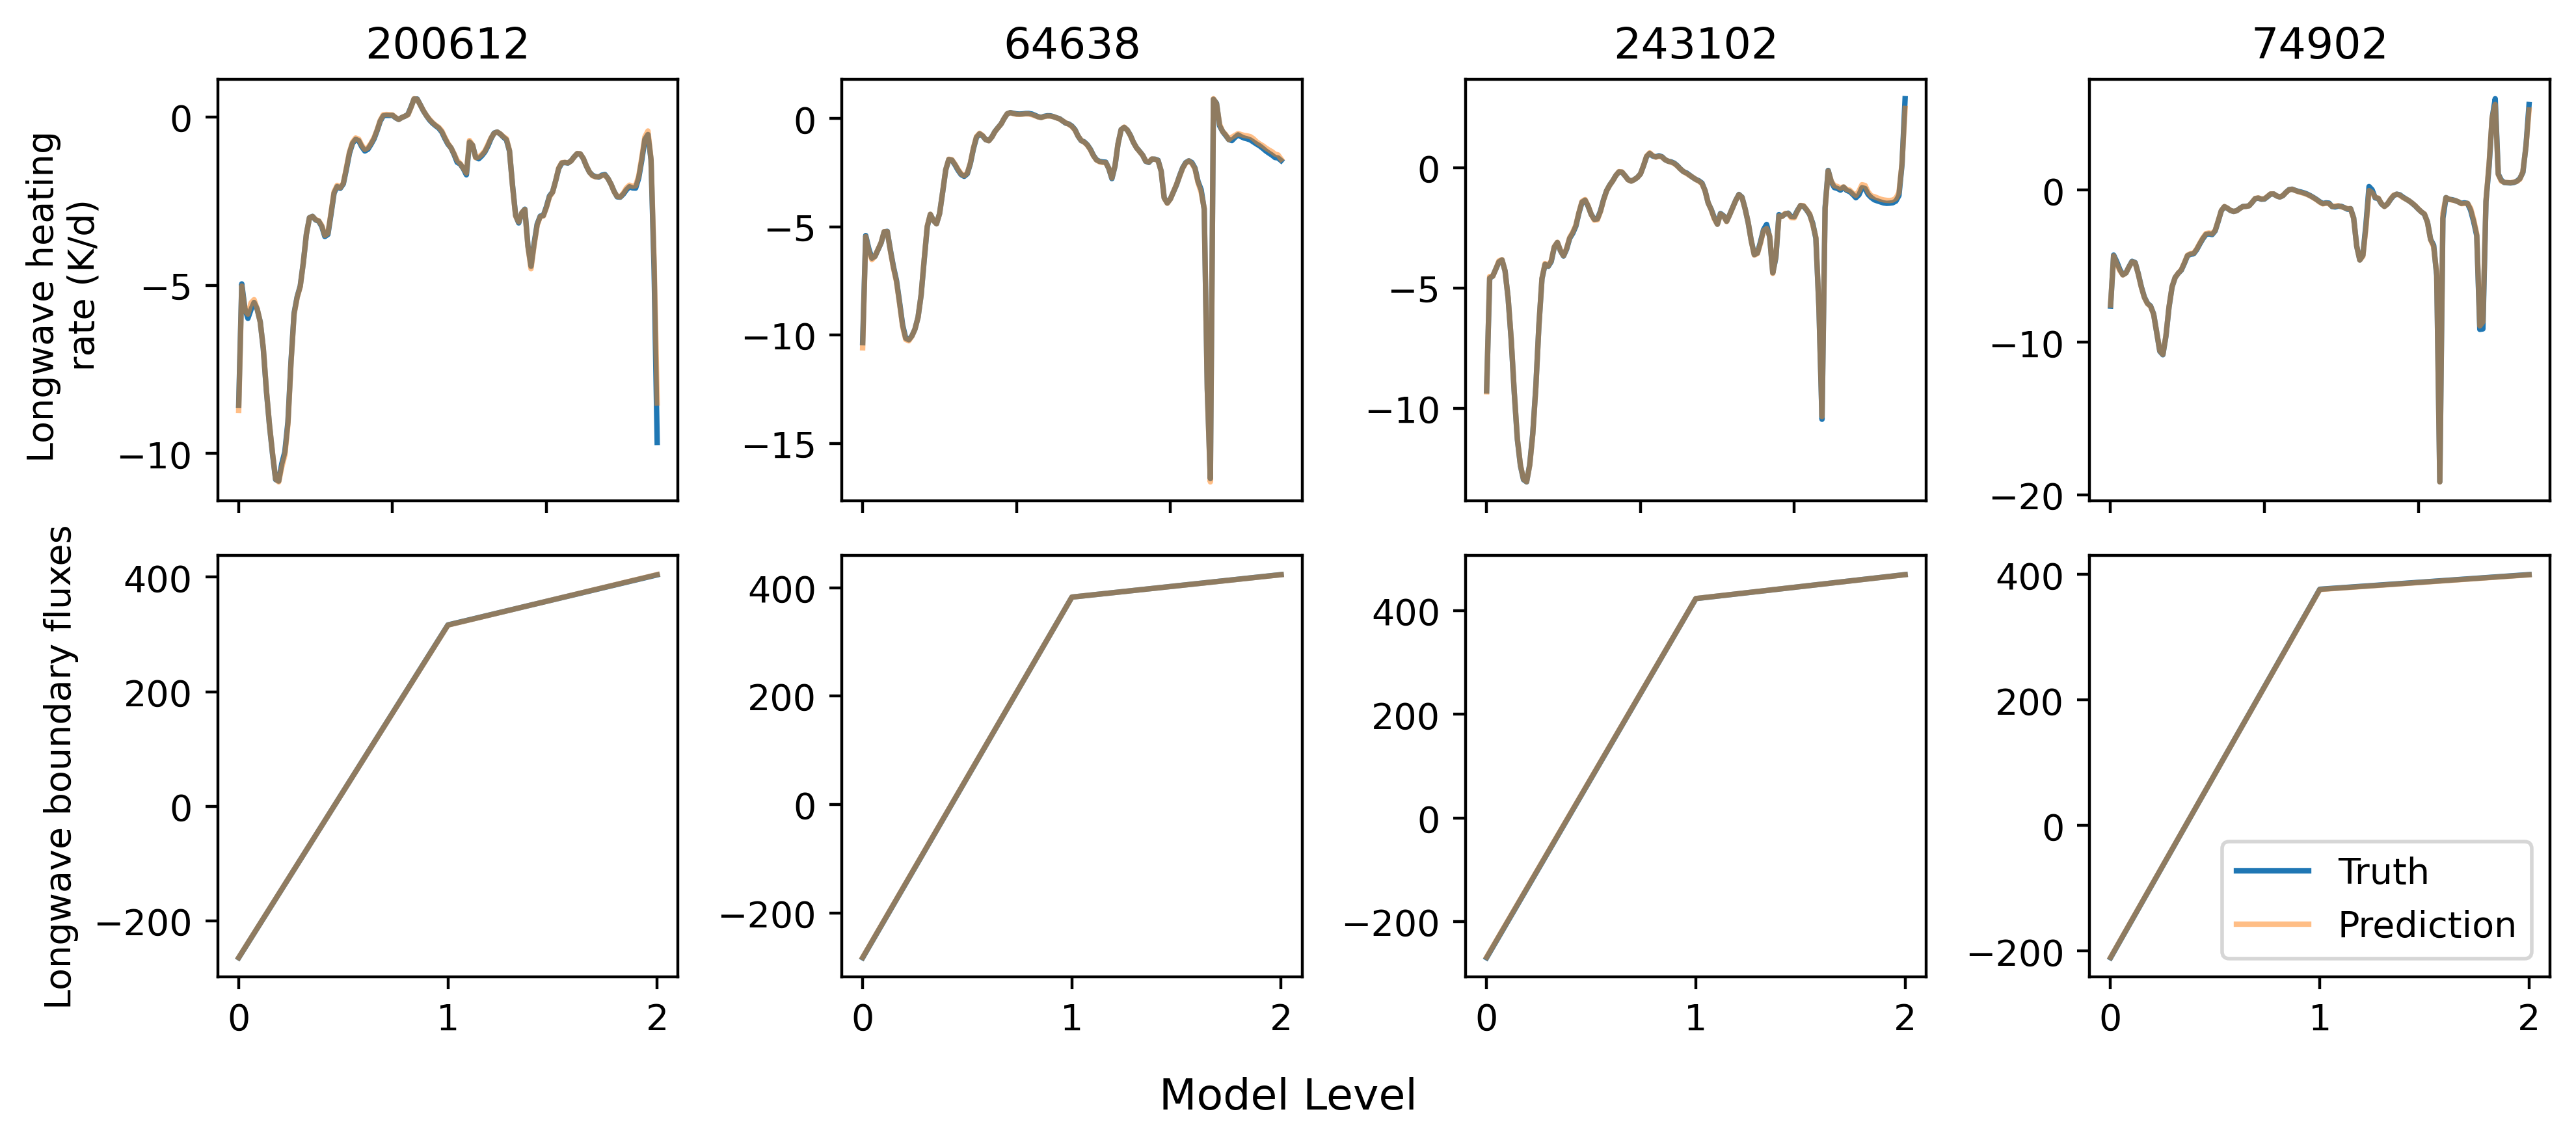

In [236]:
from importlib import reload
reload(plotting)
#This step is only necessary
plotbatch(dsx,pred,to_plot = ['hr_lw','lw'])

# Calculating metrics

Let's add a vector bias metric and a vector mse to our model and then run through some of the TF-format validation dataset (as it's much quicker).

In [184]:
class BiasMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the mean bias
    """
    def __init__(self, shape, name='bias', **kwargs):
        super(BiasMetric,self).__init__(name=name,**kwargs) # handles base args (e.g., dtype)
        self.shape=shape
        self.total_cm = self.add_weight("total", shape=self.shape, initializer="zeros")
        self.total_batches = self.add_weight("batch", shape=[1], initializer="zeros")
        
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(tf.math.reduce_mean((y_true-y_pred),axis=0))
        self.total_batches.assign_add(tf.constant([1],dtype='float32'))
        #return self.total_cm
        
    def result(self):
        #print(self.total_batches.numpy())
        return self.total_cm/self.total_batches
    
    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))

class VectorMSE(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the vector mse
    """
    def __init__(self, shape, name='vmse', **kwargs):
        super(VectorMSE,self).__init__(name=name,**kwargs) # handles base args (e.g., dtype)
        self.shape=shape
        self.total_cm = self.add_weight("total", shape=self.shape, initializer="zeros")
        self.total_batches = self.add_weight("batch", shape=[1], initializer="zeros")
        
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(tf.math.reduce_mean(tf.math.square(y_true-y_pred),axis=0))
        self.total_batches.assign_add(tf.constant([1],dtype='float32'))
        #return self.total_cm
        
    def result(self):
        #print(self.total_batches.numpy())
        return self.total_cm/self.total_batches
    
    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))


In [32]:
dsf = cml.load_dataset('maelstrom-radiation-tf',
                      dataset='tripleclouds',
                      timestep=2019013100,
                      filenum = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                      output_fields = ['lw','hr_lw'],
                      minimal_outputs=True,
                      topnetflux=True,
                      hr_units = 'K d-1'
                     )

tf_ds = dsf.to_tfdataset(batch_size=256,shuffle=False)

  0%|          | 0/11 [00:00<?, ?it/s]

# Compile in the new metrics and evaluate

In [218]:
from tensorflow.keras.optimizers import Adam
model.compile(loss={'hr_lw':'mse', #tf.keras.losses.log_cosh,
                    'lw':'mse'},
                  metrics={'lw':['mae',BiasMetric([3],name='bias'),VectorMSE([3],name='vmse')],
                           'hr_lw':['mae',BiasMetric([137,1],name='bias'),VectorMSE([137,1],name='vmse')]
                          },
                  optimizer=Adam(10**(-5)))


In [219]:
metrics = model.evaluate(tf_ds,return_dict=True)

2915/2915 [==============================] - 63s 21ms/step - loss: 0.3090 - hr_lw_loss: 0.0030 - lw_loss: 0.3060 - hr_lw_mae: 0.0293 - hr_lw_bias: 9.7899e-05 - hr_lw_vmse: 0.0030 - lw_mae: 0.4196 - lw_bias: 0.0257 - lw_vmse: 0.3060


In [179]:
metrics

{'loss': 0.7638831734657288,
 'hr_lw_loss': 0.007011774927377701,
 'lw_loss': 0.7568711042404175,
 'hr_lw_mae': 0.04281173273921013,
 'hr_lw_hr_lw_bias': array([[ 0.03535412],
        [ 0.01772421],
        [-0.01242564],
        [-0.02067056],
        [-0.03273503],
        [-0.02839214],
        [-0.02271899],
        [-0.01271016],
        [ 0.0035727 ],
        [ 0.01707078],
        [ 0.02111778],
        [ 0.02248819],
        [ 0.02958917],
        [ 0.03392404],
        [ 0.02282075],
        [ 0.02614425],
        [ 0.02696601],
        [ 0.0095882 ],
        [ 0.00187739],
        [ 0.0018532 ],
        [ 0.0024904 ],
        [-0.00016564],
        [-0.00605899],
        [-0.00452626],
        [-0.00675316],
        [-0.00913627],
        [-0.01303483],
        [-0.01263805],
        [-0.01868782],
        [-0.02265699],
        [-0.01807866],
        [-0.0184047 ],
        [-0.02180243],
        [-0.02345604],
        [-0.01902605],
        [-0.01782641],
        [-0.0185370

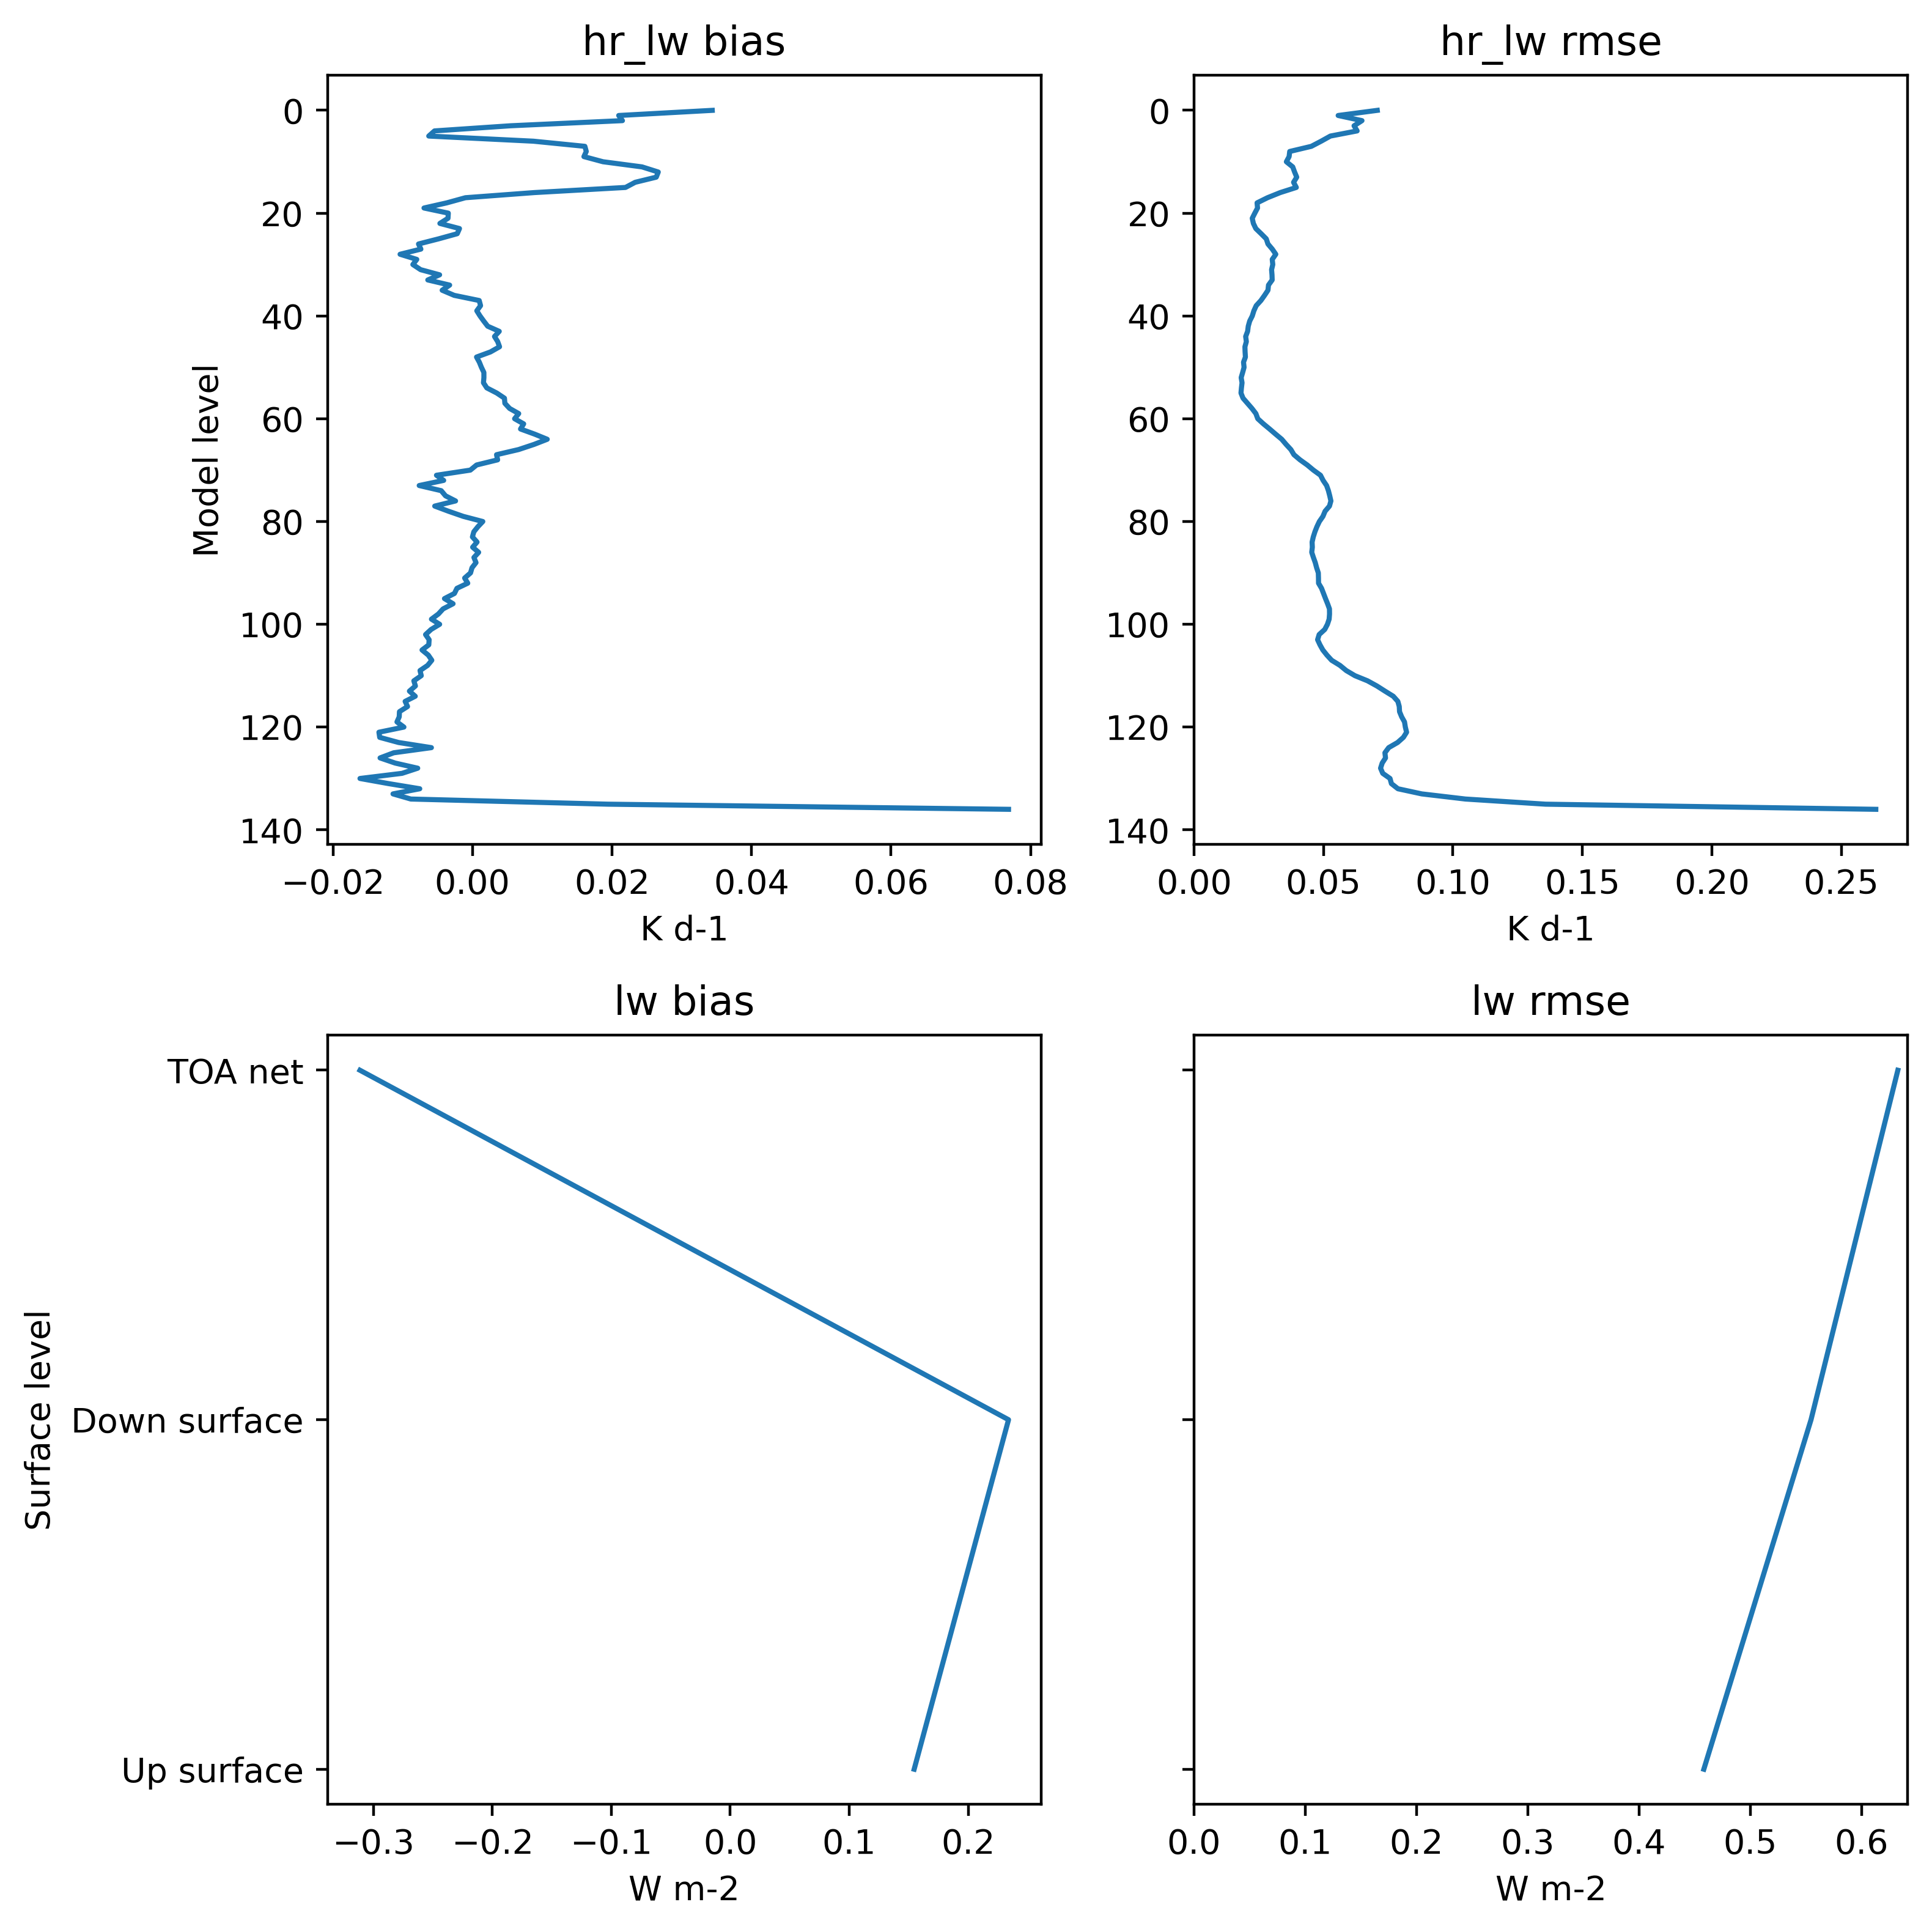

In [220]:
plt.figure(figsize=(8,8),dpi=400)
ax1 = plt.subplot(2,2,1)
plt.title('hr_lw bias')
ax1.plot(metrics['hr_lw_bias'],np.arange(137))
ax1.invert_yaxis()
plt.ylabel('Model level')
plt.xlabel('K d-1')
ax1 = plt.subplot(2,2,2)
plt.title('hr_lw rmse')
ax1.plot(metrics['hr_lw_vmse']**0.5,np.arange(137))
plt.xlim([0, None])
ax1.invert_yaxis()
plt.xlabel('K d-1')

ylabels = ['TOA net','Down surface','Up surface']

ax1 = plt.subplot(2,2,3)
plt.title('lw bias')
ax1.plot(metrics['lw_bias'],ylabels)
ax1.invert_yaxis()
plt.ylabel('Surface level')
plt.xlabel('W m-2')
ax1 = plt.subplot(2,2,4)
plt.title('lw rmse')
ax1.plot(metrics['lw_vmse']**0.5,ylabels)
plt.xlim([0, None])
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
ax1.invert_yaxis()
plt.xlabel('W m-2')
plt.tight_layout()